This notebook demonstrates the use of LogSoftmax function as a final layer in CNN of resnet network to determine the classes that are present in the image. The data set that was used identify the items in a shopping cart.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Running the notebook on AWS P instance(s). Counting the GPU instances

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.device(1)

Path indicates where the data is stored. <br>
sz indicates the image size that will be resized too. <br>
Resnext50 is the CNN architecture that was used to train on. <br>
batch size indicates no of images used in each iteration <br>

In [5]:
PATH = 'data/cart/'
sz = 300
arch = resnext50
bs = 8

Read the CSV file that has image name and classes 

In [6]:
label_csv = f'{PATH}Items.csv'
n = len(list(open(label_csv)))-1 # removing for header
val_idxs = get_cv_idxs(n)

In [7]:
os.listdir(PATH)

['tmp', 'Items.csv', 'models', 'train', 'test']

In [8]:
label_df = pd.read_csv(label_csv)
label_df.head()

,Image,Labels
0,DSC_0214,NaturePath
1,DSC_0215,NaturePath
2,DSC_0216,NaturePath
3,DSC_0217,NaturePath
4,DSC_0218,NaturePath


Pivot the information on the CSV table, the Train/Validation set has images that contain only one class per image

In [9]:
label_df.pivot_table(index='Labels', aggfunc=len).sort_values('Image', ascending=False)

,Image
Labels,
NaturePath,34
Belvita,32
NatureValley,32
RxBar,25
Eggs,21
Nutiva,21


Fast AI helper library that has dataloader to load data and transform the images (side/on and top/down and random zoom between 1 and 1.1)

In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_top_down, max_zoom = 1.1)

data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}Items.csv', test_name ='test', val_idxs=val_idxs, tfms = tfms, bs= bs,suffix ='.JPG')

In [11]:
fn = PATH+data.trn_ds.fnames[0]
fn

'data/cart/train/DSC_0214.JPG'

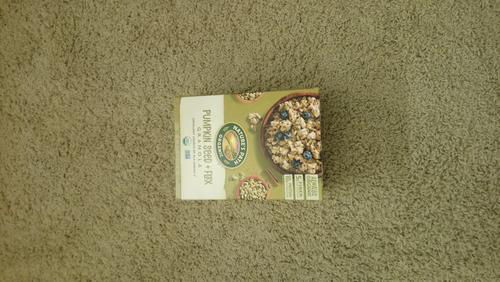

In [12]:
img = PIL.Image.open(fn)
img

In [13]:
print('Training data {}'.format(len(data.trn_ds)))
print('Validation data {}'.format(len(data.val_ds)))
print('Test data {}'.format(len(data.test_ds)))

Training data 132
Validation data 33
Test data 30


In [14]:
#Not used
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name ='test', num_workers=4, val_idxs =val_idxs, tfms = tfms, bs =bs, suffix='.JPG')
    return data if sz > 400 else data.resize(500,'tmp')

Train the last 2 layers of pre-trained resent50 with learning rate of 1e-2 and 2 epoch's'

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.75054    0.22528    0.939394  
    1      0.444508   0.127478   0.939394         



[array([0.12748]), 0.9393939393939394]

In [16]:
learn

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=4096, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=6, bias=True)
  (7): LogSoftmax()
)

Predict on the validation set (33 items)

In [17]:
log_preds = learn.predict()

In [18]:
preds = np.argmax(log_preds, axis=1) # take the max value along a given row
preds

array([2, 2, 2, 2, 2, 2, 3, 3, 0, 5, 3, 2, 2, 2, 0, 0, 0, 0, 0, 5, 5, 5, 5, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1])

In [19]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy          
    0      0.436742   2190.760346 0.363636  



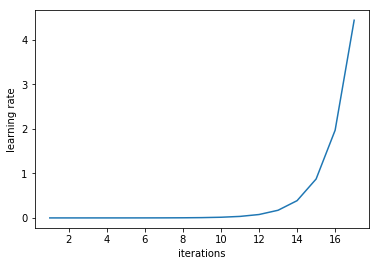

In [20]:
learn.sched.plot_lr()

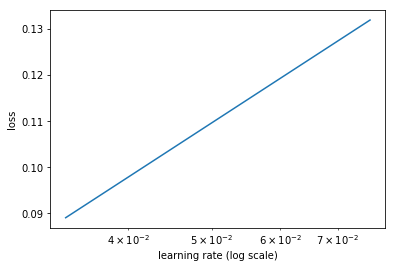

In [21]:
learn.sched.plot()

In [22]:
learn.precompute = False

In [23]:
learn.fit(1e-1, 3, cycle_len=1) # tends to overfit to due to less data

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.561318   0.2293     0.939394  
    1      0.777067   0.393035   0.939394                  
    2      0.800363   0.755066   0.909091                  



[array([0.75507]), 0.9090909090909091]

In [24]:
# learn.fit(1e-1, 2, cycle_len=1,cycle_mult=2)

Augment the test data(each image is rotated to create 4 images )

In [25]:
log_preds, y = learn.TTA()

In [26]:
log_preds.shape

(5, 33, 6)

In [27]:
probs = np.mean(np.exp(log_preds),0)

In [28]:
probs

array([[0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.99995, 0.00005, 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 1.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 1.     , 0.     , 0.     ],
       [0.53719, 0.     , 0.00015, 0.17028, 0.00262, 0.28976],
       [0.63572, 0.     , 0.00003, 0.18939, 0.0005 , 0.17436],
       [0.     , 0.     , 0.     , 1.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.99989, 0.     , 0.     , 0.00011, 0.     , 0.

In [29]:
y

array([2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 0, 0, 0, 0, 0, 5, 5, 5, 5, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1])

In [30]:
accuracy_np(probs,y)

0.9393939393939394

Running the prediction function on the images inside the test folder

In [31]:
test_pred = learn.predict(is_test=True)

In [32]:
test_pred.shape

(30, 6)

In [33]:
np.exp(test_pred)

array([[0.     , 0.     , 0.00001, 0.     , 0.99999, 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.00001, 0.     , 0.00003, 0.99995, 0.00001, 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.     ],
       [0.00051, 0.14226, 0.01181, 0.77413, 0.07125, 0.00005],
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.00001, 0.     , 0.     , 0.     , 0.99999, 0.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.     ],
       [0.99999, 0.     , 0.00001, 0.     , 0.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.99255, 0.     , 0.00035, 0.0071 , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 1.     , 0.     , 0.     ],
       [0.34774, 0.     , 0.     , 0.     , 0.65226, 0.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.

Doing Test Time Augmentation for the images inside the test folder

In [34]:
test_prob,_ =learn.TTA(is_test=True)

In [35]:
test_prob.shape

(5, 30, 6)

In [36]:
# np.exp(test_prob)

In [37]:
test_probs = np.mean(np.exp(test_prob),0)

In [38]:
test_probs

array([[0.     , 0.     , 0.     , 0.     , 1.     , 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.18546, 0.     , 0.7882 , 0.00274, 0.02284, 0.00076],
       [0.1965 , 0.     , 0.00033, 0.75302, 0.05014, 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.     ],
       [0.01366, 0.05843, 0.14708, 0.64741, 0.13338, 0.00004],
       [0.98679, 0.     , 0.00001, 0.00005, 0.01314, 0.     ],
       [0.00067, 0.     , 0.     , 0.     , 0.99933, 0.     ],
       [0.     , 0.99987, 0.00002, 0.00005, 0.00005, 0.     ],
       [0.9999 , 0.     , 0.00004, 0.00001, 0.00005, 0.     ],
       [0.     , 0.     , 1.     , 0.     , 0.     , 0.     ],
       [0.20728, 0.07452, 0.00595, 0.71222, 0.00002, 0.     ],
       [0.     , 0.     , 0.     , 1.     , 0.     , 0.     ],
       [0.62864, 0.     , 0.     , 0.     , 0.37136, 0.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.

Randomly pick 5 images and observe how well it identified each class

In [39]:
list_paths = ['data/cart/test/DSC_0414.JPG', 'data/cart/test/DSC_0435.JPG', 'data/cart/test/DSC_0331.JPG','data/cart/test/DSC_0407.JPG','data/cart/test/DSC_0468.JPG']

In [40]:
data.test_ds.fnames

['test/DSC_0362.JPG',
 'test/DSC_0274.JPG',
 'test/DSC_0233.JPG',
 'test/DSC_0455.JPG',
 'test/DSC_0341.JPG',
 'test/DSC_0379.JPG',
 'test/DSC_0414.JPG',
 'test/DSC_0448.JPG',
 'test/DSC_0370.JPG',
 'test/DSC_0400.JPG',
 'test/DSC_0302.JPG',
 'test/DSC_0220.JPG',
 'test/DSC_0435.JPG',
 'test/DSC_0264.JPG',
 'test/DSC_0349.JPG',
 'test/DSC_0392.JPG',
 'test/DSC_0454.JPG',
 'test/DSC_0421.JPG',
 'test/DSC_0331.JPG',
 'test/DSC_0442.JPG',
 'test/DSC_0315.JPG',
 'test/DSC_0460.JPG',
 'test/DSC_0386.JPG',
 'test/DSC_0252.JPG',
 'test/DSC_0407.JPG',
 'test/DSC_0404.JPG',
 'test/DSC_0462.JPG',
 'test/DSC_0427.JPG',
 'test/DSC_0295.JPG',
 'test/DSC_0468.JPG']

titles are created for each image that was picked for observation, by zipping the classes and prediction and converting the tuple to a string

In [41]:
testfile1pred= zip(data.classes, test_probs[6])
testfile2pred= zip(data.classes, test_probs[12])
testfile3pred= zip(data.classes, test_probs[18])
testfile4pred= zip(data.classes, test_probs[24])
testfile5pred= zip(data.classes, test_probs[29])

title1 = ' '.join(''.join(str(x)) for x in testfile1pred)
title2 = ' '.join(''.join(str(x)) for x in testfile2pred)
title3 = ' '.join(''.join(str(x)) for x in testfile3pred)
title4 = ' '.join(''.join(str(x)) for x in testfile4pred)
title5 = ' '.join(''.join(str(x)) for x in testfile5pred)
print(title1)

titles =[title1,title2,title3,title4,title5]

('Belvita', 0.013657567) ('Eggs', 0.058432586) ('NaturePath', 0.1470827) ('NatureValley', 0.6474079) ('Nutiva', 0.13338068) ('RxBar', 3.8624225e-05)


one of the helper method from fast ai that plots the images with titles 

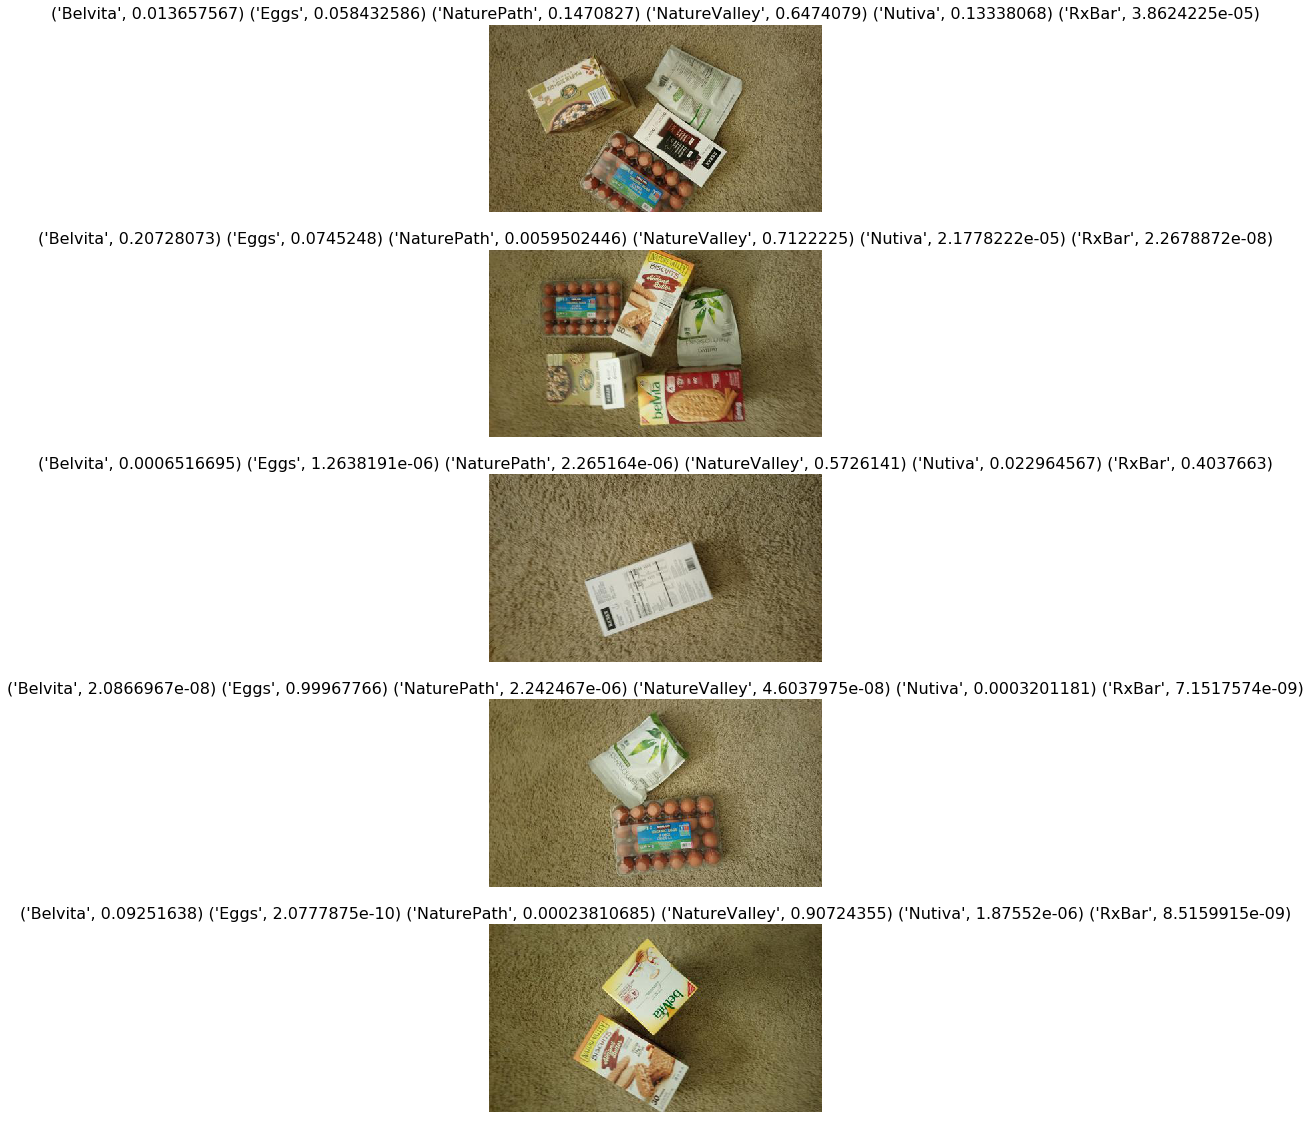

In [42]:
plots_from_files(list_paths, figsize=(20,20), rows=5, titles=titles)